In [4]:
import pandas as pd
import ast

# Load the dataset
data = pd.read_csv('synthetic_developer_data.csv')

# Function to flatten nested JSON-like columns
def flatten_column(df, column_name):
    # Convert string representation of dict to actual dict
    df[column_name] = df[column_name].apply(ast.literal_eval)
    # Normalize the column
    flattened = pd.json_normalize(df[column_name])
    # Rename columns to include the original column name
    flattened.columns = [f"{column_name}.{subcol}" for subcol in flattened.columns]
    return flattened

# Flatten all nested columns
tab_metrics_flattened = flatten_column(data, 'tabMetrics')
copy_paste_metrics_flattened = flatten_column(data, 'copyPasteMetrics')
error_metrics_flattened = flatten_column(data, 'errorMetrics')
code_metrics_flattened = flatten_column(data, 'codeMetrics')
achievements_flattened = flatten_column(data, 'achievements')
error_summary_flattened = flatten_column(data, 'errorSummary')

# Combine flattened columns with the original dataset
data_flattened = pd.concat([
    data.drop(columns=['tabMetrics', 'copyPasteMetrics', 'errorMetrics', 'codeMetrics', 'achievements', 'errorSummary']),
    tab_metrics_flattened,
    copy_paste_metrics_flattened,
    error_metrics_flattened,
    code_metrics_flattened,
    achievements_flattened,
    error_summary_flattened
], axis=1)

# Save the flattened dataset
data_flattened.to_csv('synthetic_developer_data_flattened.csv', index=False)
print("Flattened dataset saved to synthetic_developer_data_flattened.csv")

Flattened dataset saved to synthetic_developer_data_flattened.csv


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load flattened dataset
data_flattened = pd.read_csv('synthetic_developer_data_flattened.csv')
print(data_flattened.describe())
print(data_flattened.head())

# Select features and targets
features = data_flattened.select_dtypes(include=['float64', 'int64']).columns.tolist()
target_reg = 'focusScore'
target_clf = 'productivityStatus'

# Prepare data for regression
X = data_flattened[features]
y_reg = data_flattened[target_reg]

# Prepare data for classification
label_encoder = LabelEncoder()
y_clf = label_encoder.fit_transform(data_flattened[target_clf])

# Train-test split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train, X_test, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

         focusScore  currentStreak  longestStreak  sessionDuration  \
count  10000.000000   10000.000000   10000.000000     10000.000000   
mean      60.155840       2.501100       5.534600        41.885254   
std       19.078358       1.699084       2.857345        10.690089   
min        4.800000       0.000000       1.000000        -1.550311   
25%       44.900000       1.000000       3.000000        34.723396   
50%       60.100000       2.000000       6.000000        41.899531   
75%       75.500000       4.000000       8.000000        49.192731   
max      100.000000       5.000000      10.000000        80.799883   

       activeFileDuration      idleTime  typingRhythm      __v  \
count        10000.000000  10000.000000  10000.000000  10000.0   
mean           725.867441    598.145486     59.541900      0.0   
std            302.705385    265.261818     19.068141      0.0   
min           -305.961000      0.000000      4.000000      0.0   
25%            513.752250    362.576500

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import joblib
import logging
import numpy as np

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load flattened dataset
data_flattened = pd.read_csv('synthetic_developer_data_flattened.csv')

# Select features and targets
features = data_flattened.select_dtypes(include=['float64', 'int64']).columns.tolist()
target_reg = 'focusScore'
target_clf = 'productivityStatus'

# Prepare data for regression
X = data_flattened[features]
y_reg = data_flattened[target_reg]

# Prepare data for classification
label_encoder = LabelEncoder()
y_clf = label_encoder.fit_transform(data_flattened[target_clf])

# Train-test split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train, X_test, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Regression Models (Predicting focusScore)
models_reg = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regression": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regression": GradientBoostingRegressor(random_state=42)
}

# Classification Models (Predicting productivityStatus)
models_clf = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest Classification": RandomForestClassifier(random_state=42),
    "Gradient Boosting Classification": GradientBoostingClassifier(random_state=42)
}

# Evaluate Regression Models
logging.info("Evaluating Regression Models (focusScore):")
reg_results = {}
for name, model in models_reg.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train_reg, scoring='neg_mean_squared_error', cv=5)
    cv_mse = -np.mean(cv_scores)
    
    # Train and evaluate on test set
    model.fit(X_train, y_train_reg)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test_reg, y_pred)
    
    # Save results
    reg_results[name] = {
        "CV MSE": cv_mse,
        "Test MSE": mse
    }
    
    # Log results
    logging.info(f"{name}: CV MSE = {cv_mse:.4f}, Test MSE = {mse:.4f}")
    
    # Save model
    joblib.dump(model, f'{name.lower().replace(" ", "_")}_reg_model.pkl')

# Evaluate Classification Models
logging.info("\nEvaluating Classification Models (productivityStatus):")
clf_results = {}
for name, model in models_clf.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train_clf, scoring='accuracy', cv=5)
    cv_accuracy = np.mean(cv_scores)
    
    # Train and evaluate on test set
    model.fit(X_train, y_train_clf)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_clf, y_pred)
    clf_report = classification_report(y_test_clf, y_pred, target_names=label_encoder.classes_)
    
    # Save results
    clf_results[name] = {
        "CV Accuracy": cv_accuracy,
        "Test Accuracy": accuracy,
        "Classification Report": clf_report
    }
    
    # Log results
    logging.info(f"{name}: CV Accuracy = {cv_accuracy:.4f}, Test Accuracy = {accuracy:.4f}")
    logging.info(f"Classification Report:\n{clf_report}")
    
    # Save model
    joblib.dump(model, f'{name.lower().replace(" ", "_")}_clf_model.pkl')

# Save evaluation metrics to a file
with open('model_evaluation_metrics.txt', 'w') as f:
    f.write("Regression Models:\n")
    for name, metrics in reg_results.items():
        f.write(f"{name}:\n  CV MSE = {metrics['CV MSE']:.4f}\n  Test MSE = {metrics['Test MSE']:.4f}\n\n")
    
    f.write("\nClassification Models:\n")
    for name, metrics in clf_results.items():
        f.write(f"{name}:\n  CV Accuracy = {metrics['CV Accuracy']:.4f}\n  Test Accuracy = {metrics['Test Accuracy']:.4f}\n")
        f.write(f"  Classification Report:\n{metrics['Classification Report']}\n\n")

# Save preprocessing objects
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

logging.info("All models and preprocessing objects have been saved.")

2025-01-18 13:35:12,186 - INFO - Evaluating Regression Models (focusScore):
2025-01-18 13:35:12,232 - INFO - Linear Regression: CV MSE = 0.0000, Test MSE = 0.0000
2025-01-18 13:35:39,593 - INFO - Random Forest Regression: CV MSE = 0.0080, Test MSE = 0.0008
2025-01-18 13:35:50,303 - INFO - Gradient Boosting Regression: CV MSE = 0.0295, Test MSE = 0.0275
2025-01-18 13:35:50,308 - INFO - 
Evaluating Classification Models (productivityStatus):
2025-01-18 13:35:50,755 - INFO - Logistic Regression: CV Accuracy = 0.9910, Test Accuracy = 0.9875
2025-01-18 13:35:50,756 - INFO - Classification Report:
              precision    recall  f1-score   support

Distracted 😕       0.99      0.97      0.98       356
   Focused 🎯       0.99      0.99      0.99       654
   In Flow 🌊       0.98      0.99      0.99       990

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000

2025-01-18 13:35:54,

/tmp/ipykernel_46095/249744470.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['achievements.0'].fillna('No Achievement', inplace=True)


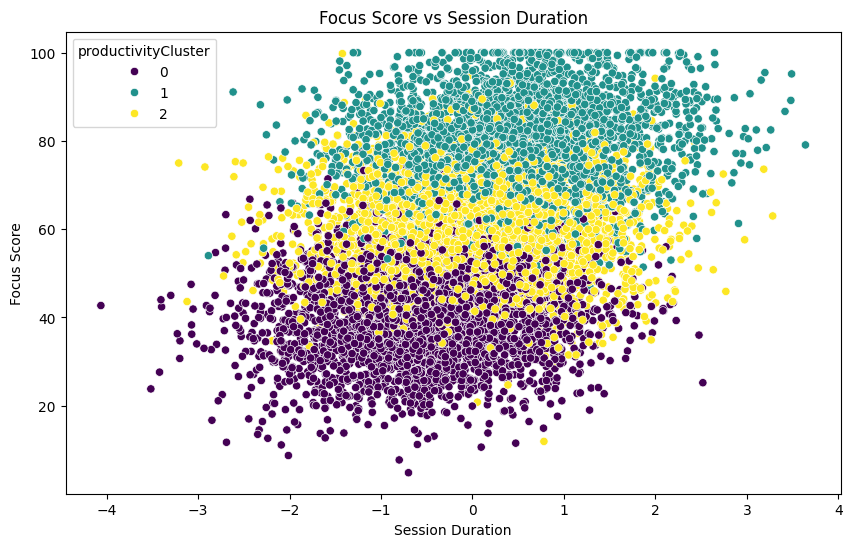

2025-01-18 13:46:03,429 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_46095/249744470.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['codeQuality'], palette='Set2')
2025-01-18 13:46:03,443 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


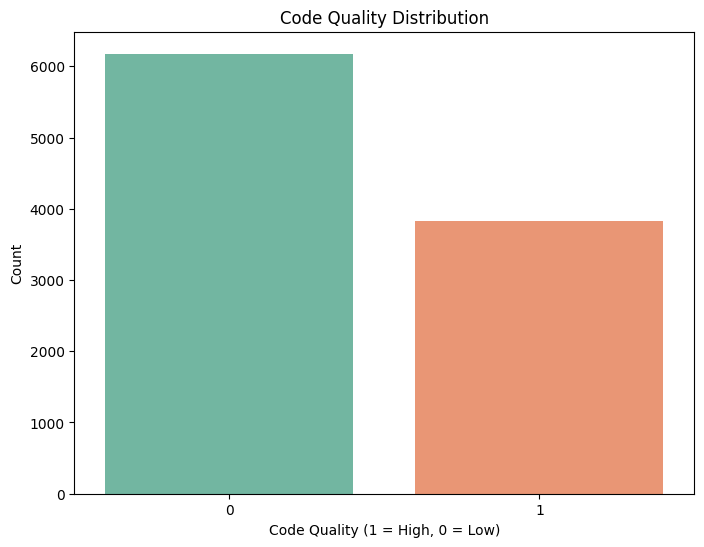

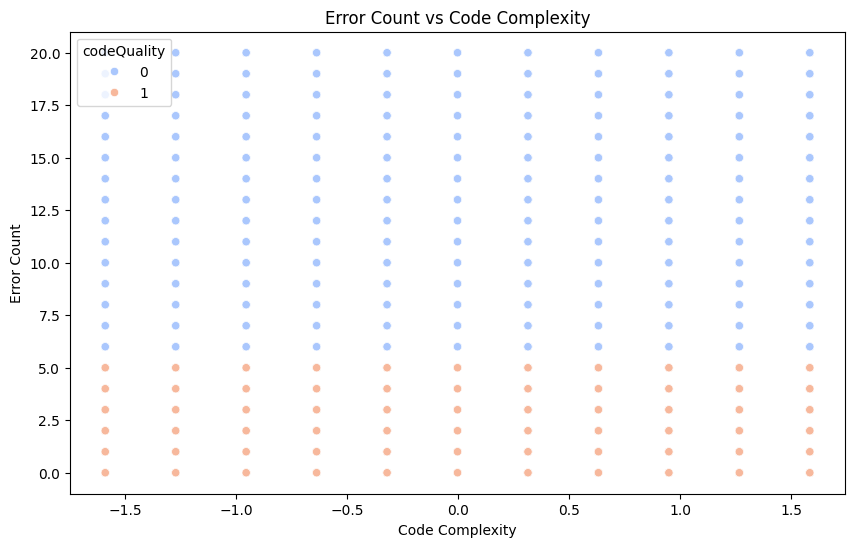

2025-01-18 13:46:03,817 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_46095/249744470.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['productivityCluster'], y=df['sessionDuration'], palette='Set3')
2025-01-18 13:46:03,829 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


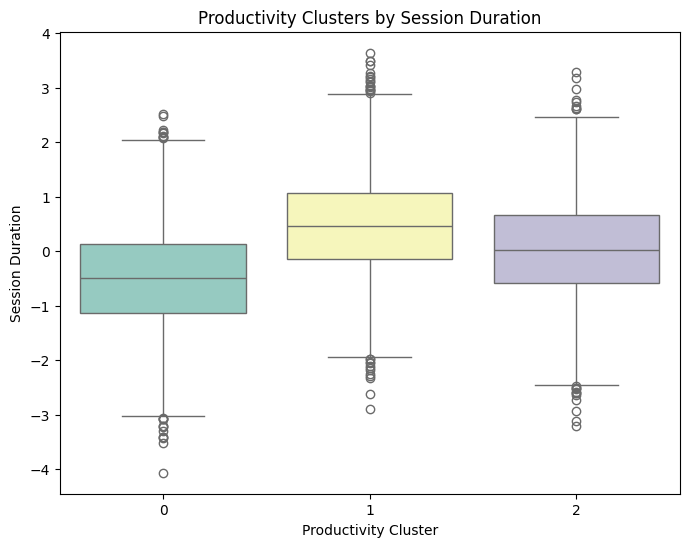

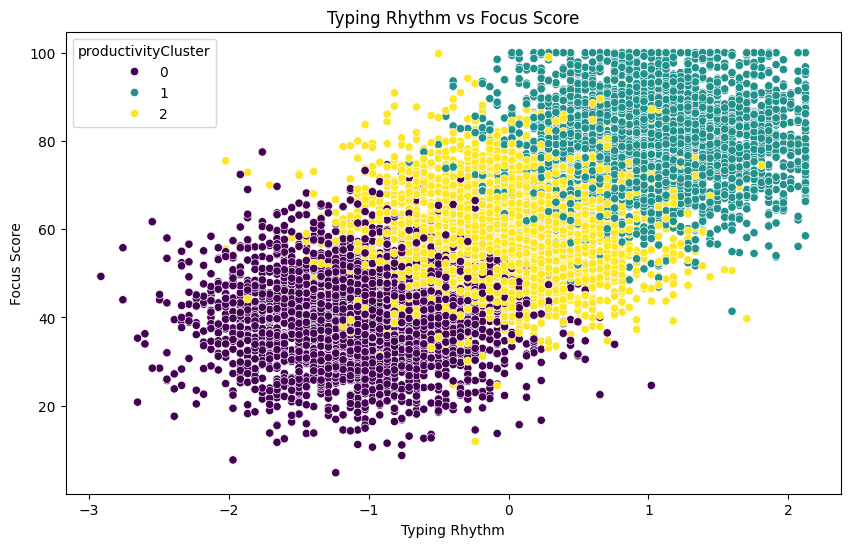

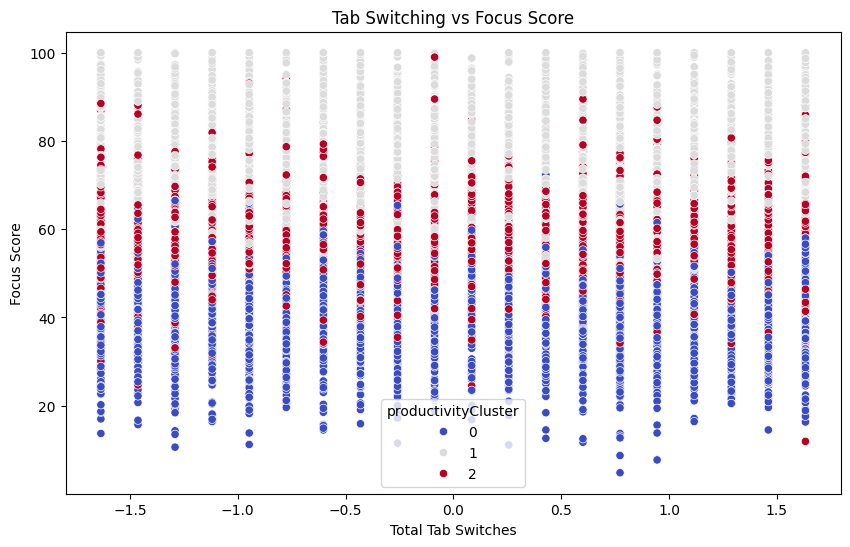

2025-01-18 13:46:04,771 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_46095/249744470.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['hasAchievement'], y=df['focusScore'], palette='Set3')
2025-01-18 13:46:04,782 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


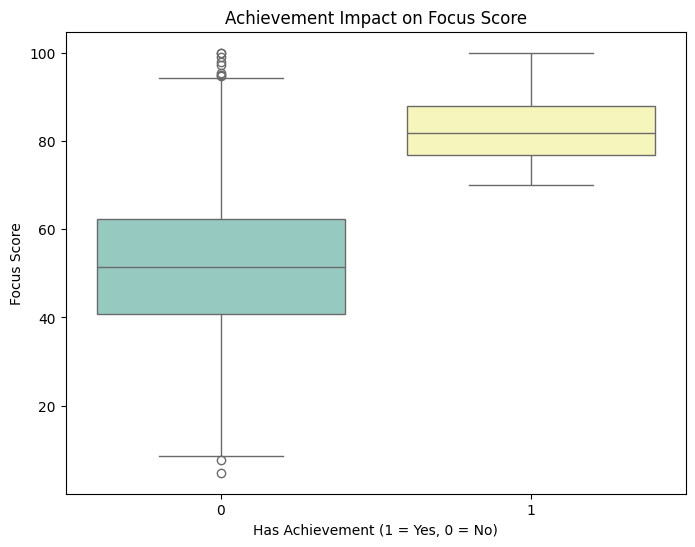

2025-01-18 13:46:04,867 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_46095/249744470.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['severityCluster'], palette='Set1')
2025-01-18 13:46:04,878 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


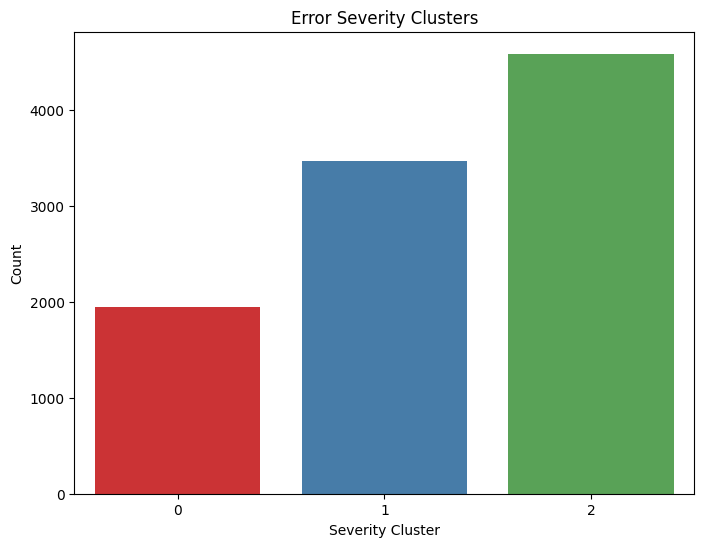

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load flattened dataset
df = pd.read_csv('synthetic_developer_data_flattened.csv')

# Data Preprocessing
# Handle missing values
df['achievements.0'].fillna('No Achievement', inplace=True)

# Normalize/Scale numerical features
scaler = StandardScaler()
numerical_features = [
    'currentStreak', 'longestStreak', 'sessionDuration', 'activeFileDuration', 
    'idleTime', 'typingRhythm', 'tabMetrics.total', 'tabMetrics.rapid', 
    'codeMetrics.linesAdded', 'codeMetrics.linesDeleted', 'codeMetrics.fileEdits', 
    'codeMetrics.codeComplexity', 'codeMetrics.testCoverage'
]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Encode categorical variables (if any)
df['userId'] = df['userId'].astype('category').cat.codes

# Feature and Target Selection
# Focus Score Prediction
X_focus = df[['currentStreak', 'longestStreak', 'sessionDuration', 'activeFileDuration', 'idleTime', 'typingRhythm']]
y_focus = df['focusScore']

# Code Quality Prediction (assuming code quality is binary: 1 = High, 0 = Low)
df['codeQuality'] = np.where(df['errorMetrics.problemCount'] <= 5, 1, 0)  # Example threshold
X_quality = df[['codeMetrics.linesAdded', 'codeMetrics.linesDeleted', 'codeMetrics.fileEdits', 'codeMetrics.codeComplexity', 'codeMetrics.testCoverage']]
y_quality = df['codeQuality']

# Error Prediction
X_error = df[['codeMetrics.linesAdded', 'codeMetrics.linesDeleted', 'codeMetrics.fileEdits', 'codeMetrics.codeComplexity', 'codeMetrics.testCoverage']]
y_error = df['errorMetrics.problemCount']

# Productivity Clustering
X_productivity = df[['sessionDuration', 'activeFileDuration', 'idleTime', 'typingRhythm']]

# Split Data
X_focus_train, X_focus_test, y_focus_train, y_focus_test = train_test_split(X_focus, y_focus, test_size=0.2, random_state=42)
X_quality_train, X_quality_test, y_quality_train, y_quality_test = train_test_split(X_quality, y_quality, test_size=0.2, random_state=42)
X_error_train, X_error_test, y_error_train, y_error_test = train_test_split(X_error, y_error, test_size=0.2, random_state=42)


# Productivity Clustering (K-Means)
kmeans = KMeans(n_clusters=3)  # 3 clusters: High, Medium, Low productivity
df['productivityCluster'] = kmeans.fit_predict(X_productivity)

# Typing Rhythm Optimization Model
X_typing = df[['typingRhythm', 'sessionDuration', 'activeFileDuration', 'idleTime']]
y_typing = df['focusScore']

# Train a regression model
typing_model = LinearRegression()
typing_model.fit(X_typing, y_typing)

# Tab Switching Impact Model
X_tab = df[['tabMetrics.total', 'tabMetrics.rapid']]
y_tab = df['focusScore']

# Train a regression model
tab_model = LinearRegression()
tab_model.fit(X_tab, y_tab)

# Code Complexity vs. Error Rate Model
X_complexity = df[['codeMetrics.codeComplexity', 'codeMetrics.testCoverage']]
y_complexity = df['errorMetrics.problemCount']

# Train a regression model
complexity_model = LinearRegression()
complexity_model.fit(X_complexity, y_complexity)

# Achievement Impact Model
# Encode achievements as binary features
df['hasAchievement'] = df['achievements.0'].apply(lambda x: 1 if x != 'No Achievement' else 0)
X_achievement = df[['hasAchievement', 'currentStreak', 'longestStreak']]
y_achievement = df['focusScore']

# Session Duration vs. Productivity Model
X_session = df[['sessionDuration', 'activeFileDuration', 'idleTime']]
y_session = df['focusScore']

# Train a regression model
session_model = LinearRegression()
session_model.fit(X_session, y_session)

# Error Severity Analysis Model
X_severity = df[['errorSummary.bySeverity.error', 'errorSummary.bySeverity.warning', 'errorSummary.bySeverity.info']]
y_severity = df['focusScore']

# Train a clustering model
severity_model = KMeans(n_clusters=3)  # 3 clusters: High, Medium, Low severity
df['severityCluster'] = severity_model.fit_predict(X_severity)

# Save Models
joblib.dump(focus_model, 'focus_score_model.pkl')
joblib.dump(quality_model, 'code_quality_model.pkl')
joblib.dump(error_model, 'error_prediction_model.pkl')
joblib.dump(kmeans, 'productivity_clustering_model.pkl')
joblib.dump(typing_model, 'typing_rhythm_model.pkl')
joblib.dump(tab_model, 'tab_switching_model.pkl')
joblib.dump(complexity_model, 'code_complexity_model.pkl')
joblib.dump(achievement_model, 'achievement_impact_model.pkl')
joblib.dump(session_model, 'session_duration_model.pkl')
joblib.dump(severity_model, 'error_severity_model.pkl')

# Visualizations
# Focus Score vs Session Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['sessionDuration'], y=df['focusScore'], hue=df['productivityCluster'], palette='viridis')
plt.title('Focus Score vs Session Duration')
plt.xlabel('Session Duration')
plt.ylabel('Focus Score')
plt.show()

# Code Quality Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=df['codeQuality'], palette='Set2')
plt.title('Code Quality Distribution')
plt.xlabel('Code Quality (1 = High, 0 = Low)')
plt.ylabel('Count')
plt.show()

# Error Count vs Code Complexity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['codeMetrics.codeComplexity'], y=df['errorMetrics.problemCount'], hue=df['codeQuality'], palette='coolwarm')
plt.title('Error Count vs Code Complexity')
plt.xlabel('Code Complexity')
plt.ylabel('Error Count')
plt.show()

# Productivity Clusters
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['productivityCluster'], y=df['sessionDuration'], palette='Set3')
plt.title('Productivity Clusters by Session Duration')
plt.xlabel('Productivity Cluster')
plt.ylabel('Session Duration')
plt.show()

# Typing Rhythm vs Focus Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['typingRhythm'], y=df['focusScore'], hue=df['productivityCluster'], palette='viridis')
plt.title('Typing Rhythm vs Focus Score')
plt.xlabel('Typing Rhythm')
plt.ylabel('Focus Score')
plt.show()

# Tab Switching vs Focus Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['tabMetrics.total'], y=df['focusScore'], hue=df['productivityCluster'], palette='coolwarm')
plt.title('Tab Switching vs Focus Score')
plt.xlabel('Total Tab Switches')
plt.ylabel('Focus Score')
plt.show()

# Achievement Impact on Focus Score
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['hasAchievement'], y=df['focusScore'], palette='Set3')
plt.title('Achievement Impact on Focus Score')
plt.xlabel('Has Achievement (1 = Yes, 0 = No)')
plt.ylabel('Focus Score')
plt.show()

# Error Severity Clusters
plt.figure(figsize=(8, 6))
sns.countplot(x=df['severityCluster'], palette='Set1')
plt.title('Error Severity Clusters')
plt.xlabel('Severity Cluster')
plt.ylabel('Count')
plt.show()

In [24]:
import pandas as pd
import joblib
import numpy as np

# Load all saved models
focus_model = joblib.load('focus_score_model.pkl')
quality_model = joblib.load('code_quality_model.pkl')
error_model = joblib.load('error_prediction_model.pkl')
productivity_model = joblib.load('productivity_clustering_model.pkl')
typing_model = joblib.load('typing_rhythm_model.pkl')
tab_model = joblib.load('tab_switching_model.pkl')
complexity_model = joblib.load('code_complexity_model.pkl')
session_model = joblib.load('session_duration_model.pkl')
severity_model = joblib.load('error_severity_model.pkl')

# Example new data (replace with actual data)
new_data = pd.DataFrame({
    'currentStreak': [3],
    'longestStreak': [7],
    'sessionDuration': [40],
    'activeFileDuration': [700],
    'idleTime': [300],
    'typingRhythm': [60],
    'tabMetrics.total': [10],
    'tabMetrics.rapid': [2],
    'codeMetrics.linesAdded': [100],
    'codeMetrics.linesDeleted': [25],
    'codeMetrics.fileEdits': [5],
    'codeMetrics.codeComplexity': [6],
    'codeMetrics.testCoverage': [50],
    'errorMetrics.problemCount': [8],
    'errorSummary.bySeverity.error': [2],
    'errorSummary.bySeverity.warning': [4],
    'errorSummary.bySeverity.info': [6],
    'achievements.0': ['No Achievement']
})

# Preprocess new data (same as training preprocessing)
numerical_features = [
    'currentStreak', 'longestStreak', 'sessionDuration', 'activeFileDuration', 
    'idleTime', 'typingRhythm', 'tabMetrics.total', 'tabMetrics.rapid', 
    'codeMetrics.linesAdded', 'codeMetrics.linesDeleted', 'codeMetrics.fileEdits', 
    'codeMetrics.codeComplexity', 'codeMetrics.testCoverage'
]
scaler = StandardScaler()
new_data[numerical_features] = scaler.fit_transform(new_data[numerical_features])

# Encode categorical variables
new_data['userId'] = 0  # Example user ID
new_data['hasAchievement'] = new_data['achievements.0'].apply(lambda x: 1 if x != 'No Achievement' else 0)

# Make predictions using all models
focus_score = focus_model.predict(new_data[['currentStreak', 'longestStreak', 'sessionDuration', 'activeFileDuration', 'idleTime', 'typingRhythm']])
code_quality = quality_model.predict(new_data[['codeMetrics.linesAdded', 'codeMetrics.linesDeleted', 'codeMetrics.fileEdits', 'codeMetrics.codeComplexity', 'codeMetrics.testCoverage']])
error_count = error_model.predict(new_data[['codeMetrics.linesAdded', 'codeMetrics.linesDeleted', 'codeMetrics.fileEdits', 'codeMetrics.codeComplexity', 'codeMetrics.testCoverage']])
productivity_cluster = productivity_model.predict(new_data[['sessionDuration', 'activeFileDuration', 'idleTime', 'typingRhythm']])
typing_rhythm_impact = typing_model.predict(new_data[['typingRhythm', 'sessionDuration', 'activeFileDuration', 'idleTime']])
tab_switching_impact = tab_model.predict(new_data[['tabMetrics.total', 'tabMetrics.rapid']])
complexity_impact = complexity_model.predict(new_data[['codeMetrics.codeComplexity', 'codeMetrics.testCoverage']])
session_impact = session_model.predict(new_data[['sessionDuration', 'activeFileDuration', 'idleTime']])
severity_cluster = severity_model.predict(new_data[['errorSummary.bySeverity.error', 'errorSummary.bySeverity.warning', 'errorSummary.bySeverity.info']])

# Generate Actionable Insights
print("\n=== Actionable Insights ===")

# Focus Score Insights
print(f"\n1. Focus Score: {focus_score[0]:.2f}")
if focus_score[0] < 50:
    print("   - Your focus score is low. Try reducing idle time and avoiding rapid tab switching.")
else:
    print("   - Your focus score is good. Keep maintaining your workflow!")

# Code Quality Insights
print(f"\n2. Code Quality: {'High' if code_quality[0] == 1 else 'Low'}")
if code_quality[0] == 0:
    print("   - Your code quality needs improvement. Focus on reducing code complexity and increasing test coverage.")

# Error Count Insights
print(f"\n3. Predicted Error Count: {error_count[0]:.2f}")
if error_count[0] > 10:
    print("   - High error count predicted. Review your code changes carefully and write more unit tests.")

# Productivity Insights
productivity_labels = {0: 'Low', 1: 'Medium', 2: 'High'}
print(f"\n4. Productivity Cluster: {productivity_labels[productivity_cluster[0]]}")
if productivity_cluster[0] == 0:
    print("   - Your productivity is low. Try scheduling shorter, more focused work sessions.")

# Typing Rhythm Insights
print(f"\n5. Typing Rhythm Impact: {typing_rhythm_impact[0]:.2f}")
if typing_rhythm_impact[0] < 50:
    print("   - Your typing rhythm is affecting your focus. Try maintaining a consistent typing speed.")

# Tab Switching Insights
print(f"\n6. Tab Switching Impact: {tab_switching_impact[0]:.2f}")
if tab_switching_impact[0] < 50:
    print("   - Excessive tab switching is reducing your focus. Avoid unnecessary tab switches.")

# Code Complexity Insights
print(f"\n7. Code Complexity Impact: {complexity_impact[0]:.2f}")
if complexity_impact[0] > 7:
    print("   - High code complexity detected. Consider refactoring your code to improve maintainability.")

# Session Duration Insights
print(f"\n9. Session Duration Impact: {session_impact[0]:.2f}")
if session_impact[0] < 50:
    print("   - Your session duration is too short. Try longer, uninterrupted work sessions.")

# Error Severity Insights
severity_labels = {0: 'Low', 1: 'Medium', 2: 'High'}
print(f"\n10. Error Severity Cluster: {severity_labels[severity_cluster[0]]}")
if severity_cluster[0] == 2:
    print("   - High-severity errors detected. Prioritize fixing these errors to improve code quality.")

print("\n=== End of Insights ===")


=== Actionable Insights ===

1. Focus Score: 56.27
   - Your focus score is good. Keep maintaining your workflow!

2. Code Quality: Low
   - Your code quality needs improvement. Focus on reducing code complexity and increasing test coverage.

3. Predicted Error Count: 6.58

4. Productivity Cluster: High

5. Typing Rhythm Impact: 60.16

6. Tab Switching Impact: 60.16

7. Code Complexity Impact: 7.55
   - High code complexity detected. Consider refactoring your code to improve maintainability.

9. Session Duration Impact: 60.16

10. Error Severity Cluster: High
   - High-severity errors detected. Prioritize fixing these errors to improve code quality.

=== End of Insights ===
